In [1]:
# train_model.py

import torch

no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

import torchvision

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

from analogymodel.custom_mnist_dataset import LoadByPathAllAnalogyDataset, LoadByPathAnalogyDataset, LoadByPathRawDataset
    
training_dataset = LoadByPathAllAnalogyDataset(file_path='dataset/toy-train-100.csv',
    number_of_class=10, number_of_img=100, 
    transform=transform,
    percent=1.
    )

# You can have 'same_class_percent=1., different_class_percent_3=1., different_class_percent_4=1.'
# to use unbalanced dataset

develop_dataset = LoadByPathAnalogyDataset(file_path='dataset/toy-dev.csv', transform=transform)
testing_dataset = LoadByPathAnalogyDataset(file_path='dataset/toy-test.csv', transform=transform)

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
dev_loader = torch.utils.data.DataLoader(develop_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=1000, shuffle=False)

720 720
0 0
0 0
0 0


In [2]:
from analogymodel.model_analogy import AnalogyModel

In [3]:
# analogy model

model = AnalogyModel(
size=784, # size of MNIST image [28X28] = [784]
input_layers=[128, 128, 128],
decision_layers=[64, 64],
act='relu',
using_analogy_fn=True,
using_shared_weight=True
)

In [4]:
enable_multiple_gpus = False
if torch.cuda.device_count() > 1:
    print('This machine support multiple GPUs')
    if enable_multiple_gpus:
        logging.info('Using multiple GPUs')
        model = nn.DataParallel(model)
model = model.to(device)

In [5]:
log_interval = 100 # log every 100 epoch
# epochs = 500
epochs = 50
dev_epoch = 5 # check every 5 epoch
stop_epoch = 20 # stop after no improvment for 20 epoches
custom_name = 'toy'

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (imgs, labels, gt) in enumerate(train_loader):
        target = gt.type(torch.FloatTensor).view(gt.shape[0], 1)
        imgs[0], imgs[1], imgs[2], imgs[3], target = imgs[0].to(device), imgs[1].to(device), imgs[2].to(device), imgs[3].to(device), target.to(device)
        optimizer.zero_grad()
        output, emb_a, emb_b, emb_c, emb_d = model(imgs[0], imgs[1], imgs[2], imgs[3])
        loss = criteria(output, target)
        total_loss += loss.item()
        sum_loss = loss
        sum_loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('[Epoch {}/{}] [Batch {}/{}] [loss: {:.6f}]'.format(
                epoch, epochs, batch_idx, len(train_loader), sum_loss.item()
                ))
    total_loss /= len(train_loader)
    print('[Epoch {}/{}] [loss: {:.6f}]'.format(epoch, epochs, total_loss))
    return total_loss

def test(model, device, test_loader, validate=True, save_output=False):
    model.eval()
    total_loss = 0
    correct = 0
    if save_output:
        f = open('answer/'+custom_name+'-answer.txt',"w")
    with torch.no_grad():
        for imgs, labels, gt in test_loader:
            target = gt.type(torch.FloatTensor).view(gt.shape[0], 1)
            imgs[0], imgs[1], imgs[2], imgs[3], target = imgs[0].to(device), imgs[1].to(device), imgs[2].to(device), imgs[3].to(device), target.to(device)
            output, emb_a, emb_b, emb_c, emb_d = model(imgs[0], imgs[1], imgs[2], imgs[3])
            total_loss += criteria(output, target).item()
            pred = output.round()
            if save_output :
                for i in range(len(pred)):
                    f.write('%d\n' % (pred[i]))
            correct += pred.eq(target.view_as(pred)).sum().item()
    if save_output:
        f.close()
    total_loss /= len(test_loader)
    acc = 100. * correct / len(test_loader.dataset)
    if validate:
        print('[Validate] [Avg. loss: {:.6f}] [Accuracy: {}/{} ({:.2f}%)]'.format(
            total_loss, correct, len(test_loader.dataset), acc))
    else:
        print('[Test] [Avg. loss: {:.6f}] [Accuracy: {}/{} ({:.2f}%)]'.format(
            total_loss, correct, len(test_loader.dataset), acc))
    return total_loss, acc

In [6]:
import torch.optim as optim
from analogymodel.custom_function import *

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
criteria = get_criteria_fn('BCE')

# Init for chart
train_loss = []
dev_loss = []
accuracies = []
axis = []
axis_dev = []
test_loss = []
test_accuracies = []

min_data = 100
stop_counter = 0

for epoch in range(1, epochs + 1):
    train_loss_data = train(model, device, train_loader, optimizer, epoch)
    if epoch % dev_epoch == 0:
        dev_loss_data, acc_data  = test(model, device, dev_loader)
        comp_data = dev_loss_data
        if epoch == 1 or comp_data < min_data :
            stop_counter = 0
            min_data = comp_data
            print('[ === Test === ]')
            test_loss_data, test_acc_data = test(model, device, test_loader, False, False)
            name = ('model/temp_model.pt')
            torch.save(model.state_dict(), name)
        else:
            stop_counter = stop_counter + 1
        # Resource for Chart
        axis_dev.append(epoch)
        dev_loss.append(dev_loss_data)
        accuracies.append(acc_data)
    axis.append(epoch)
    train_loss.append(train_loss_data)

    # special function for reload the dataset
    training_dataset.reload()
    if stop_counter >= stop_epoch:
        print('[ === BREAK === ]')
        break

[Epoch 1/50] [Batch 0/12] [loss: 0.696880]
[Epoch 1/50] [loss: 0.690477]
[Epoch 2/50] [Batch 0/12] [loss: 0.681244]
[Epoch 2/50] [loss: 0.645164]
[Epoch 3/50] [Batch 0/12] [loss: 0.649330]
[Epoch 3/50] [loss: 0.556491]
[Epoch 4/50] [Batch 0/12] [loss: 0.631780]
[Epoch 4/50] [loss: 0.494743]
[Epoch 5/50] [Batch 0/12] [loss: 0.433934]
[Epoch 5/50] [loss: 0.428243]
[Validate] [Avg. loss: 0.454762] [Accuracy: 554/720 (76.94%)]
[ === Test === ]
[Test] [Avg. loss: 0.447206] [Accuracy: 577/720 (80.14%)]
[Epoch 6/50] [Batch 0/12] [loss: 0.365207]
[Epoch 6/50] [loss: 0.368724]
[Epoch 7/50] [Batch 0/12] [loss: 0.283777]
[Epoch 7/50] [loss: 0.331926]
[Epoch 8/50] [Batch 0/12] [loss: 0.290315]
[Epoch 8/50] [loss: 0.293735]
[Epoch 9/50] [Batch 0/12] [loss: 0.259625]
[Epoch 9/50] [loss: 0.247853]
[Epoch 10/50] [Batch 0/12] [loss: 0.270457]
[Epoch 10/50] [loss: 0.211925]
[Validate] [Avg. loss: 0.378414] [Accuracy: 600/720 (83.33%)]
[ === Test === ]
[Test] [Avg. loss: 0.388187] [Accuracy: 600/720 (83.

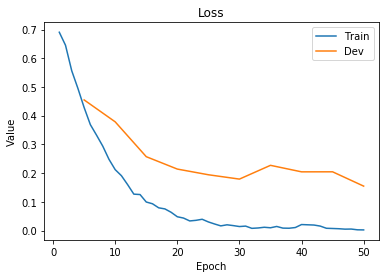

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

fig = plt.figure()
plt.title("Loss");
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.plot(axis, train_loss, label='Train')
plt.plot(axis_dev, dev_loss, label='Dev')
plt.legend()
plt.show()

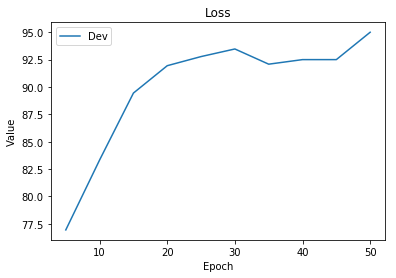

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

fig = plt.figure()
plt.title("Loss");
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.plot(axis_dev, accuracies, label='Dev')
plt.legend()
plt.show()